# Heart disease Prediction

In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Importing the Data

In [232]:
df_raw= pd.read_csv('heart.csv')

In [233]:
df=df_raw.copy()

In [234]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Data Wrangling

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [236]:
df.shape

(918, 12)

In [237]:
df.duplicated().sum()

0

In [238]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


### Null Value Check

In [239]:
per_null=(df.isna().sum()/df.shape[0])*100
per_null

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64

## Hypothesis Testing

In [240]:
columns=df.columns
columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [241]:
df['HeartDisease'].unique()

array([0, 1], dtype=int64)

In [242]:
df['HeartDisease']=df['HeartDisease'].map({0:'No', 1:'Yes'})

In [243]:
not_numeric=[]
for label,content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        not_numeric.append(label)
not_numeric

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'HeartDisease']

In [244]:
for col in not_numeric:
    print(f"\033[1m{col} \n{20 * '-'}\033[0m")
    print(f"\033[1m Unique :{df[col].nunique()}\n{20 * '-'}\033[0m")
    print(f"{20 * '-'}")
    print(df[col].value_counts(), '\n')

Sex 
--------------------
 Unique :2
--------------------
--------------------
M    725
F    193
Name: Sex, dtype: int64 

ChestPainType 
--------------------
 Unique :4
--------------------
--------------------
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64 

RestingECG 
--------------------
 Unique :3
--------------------
--------------------
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64 

ExerciseAngina 
--------------------
 Unique :2
--------------------
--------------------
N    547
Y    371
Name: ExerciseAngina, dtype: int64 

ST_Slope 
--------------------
 Unique :3
--------------------
--------------------
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64 

HeartDisease 
--------------------
 Unique :2
--------------------
--------------------
Yes    508
No     410
Name: HeartDisease, dtype: int64 



In [245]:
numeric = []
for label,content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        numeric.append(label)
numeric

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

## ANOVA Test

In [246]:
from scipy.stats import f_oneway

In [247]:
def perform_Anova_test_regression(data_frame, list_of_column, Target_column):
    
    '''
    Take the inputs from dataframe and conduct the T-Test fror Numeric Variable and Target Numeric Variable.
    Returns Data frame with P-value and Decision
    
        Parameters:
                data_frame(Data Frame):Pandas Data Farame
                list_of_column: List of Categorical Columns  
                Target_column(str): Target Numeric Label (Regression Value) should be in " " 
        
        Returns:
                PvalueTable(Data Frame): Data frame with P-value and Decision
    '''
    pvalNum=[]
    for col in list_of_column:
        # Running the one-way anova test 
        # Assumption(H0) is that variable are NOT correlated

        CategoryGroupLists=data_frame.groupby(Target_column)[col].apply(list)
        #print(CategoryGroupLists)

        # Performing the ANOVA test
        # We accept the Assumption(H0) only when P-Value &gt; 0.05
        AnovaResults = f_oneway(*CategoryGroupLists)
        pvalNum.append(AnovaResults[1])
        #print('P-Value for Anova is: ', AnovaResults[1])
        
    dict={'P-Value of the Anova_Test':pvalNum}
    PvalueTable=pd.DataFrame(dict,index=list_of_column)
    PvalueTable['Decision']=PvalueTable['P-Value of the Anova_Test'].apply(lambda row:'Reject Null Hypothesis' 
                                                                       if row<0.05 
                                                                       else 'Fail to reject Null Hypothesis')
    return PvalueTable

In [248]:
perform_Anova_test_regression(df,numeric[:-1],'HeartDisease')

,P-Value of the Anova_Test,Decision
Age,3.007953e-18,Reject Null Hypothesis
RestingBP,1.095315e-03,Reject Null Hypothesis
Cholesterol,9.308309e-13,Reject Null Hypothesis
FastingBS,1.753598e-16,Reject Null Hypothesis
MaxHR,1.137786e-36,Reject Null Hypothesis


## Chi-Square Test

In [249]:
from scipy.stats import chi2_contingency

In [250]:
def perform_ChiSquare_test(data_frame, list_of_column, Target_column):  
        
    '''
    Take the inputs from dataframe and conduct the T-Test fror Numeric Variable and Target Numeric Variable.
    Returns Data frame with P-value and Decision
    
        Parameters:
                data_frame(Data Frame):Pandas Data Farame
                list_of_column: List of Categorical Columns  
                Target_column(str): Target Numeric Label (Regression Value) should be in " " 
        
        Returns:
                PvalueTable(Data Frame): Data frame with P-value and Decision
    '''
    pvalCat=[]
    
    for col in list_of_column:
        CrosstabResult=pd.crosstab(index=df[col],columns=df[Target_column])
    #print(CrosstabResult)    

    # Performing Chi-sq test
        ChiSqResult = chi2_contingency(CrosstabResult)
        pvalCat.append(ChiSqResult[1])

    # P-Value is the Probability of H0 being True
    # If P-Value&gt;0.05 then only we Accept the assumption(H0)\
    #print('The P-Value of the ChiSq Test is:', ChiSqResult[1]))

    dict={'P-Value of the ChiSq Test':pvalCat}
    PvalueTable=pd.DataFrame(dict,index=list_of_column)
    PvalueTable['Decision']=PvalueTable['P-Value of the ChiSq Test'].apply(lambda row:'Reject Null Hypothesis' 
                                                                       if row<0.05 
                                                                       else 'Fail to reject Null Hypothesis')
    return PvalueTable

In [251]:
perform_ChiSquare_test(df,not_numeric,'HeartDisease')

,P-Value of the ChiSq Test,Decision
Sex,4.597617e-20,Reject Null Hypothesis
ChestPainType,8.083728e-58,Reject Null Hypothesis
RestingECG,4.229233e-03,Reject Null Hypothesis
ExerciseAngina,2.907808e-50,Reject Null Hypothesis
ST_Slope,5.167638e-78,Reject Null Hypothesis
HeartDisease,9.067123e-201,Reject Null Hypothesis


In [252]:
df['HeartDisease']=df['HeartDisease'].map({'No':0,'Yes':1})

In [253]:
df['HeartDisease'].unique()

array([0, 1], dtype=int64)

## Multicollinearity Check

<AxesSubplot:>

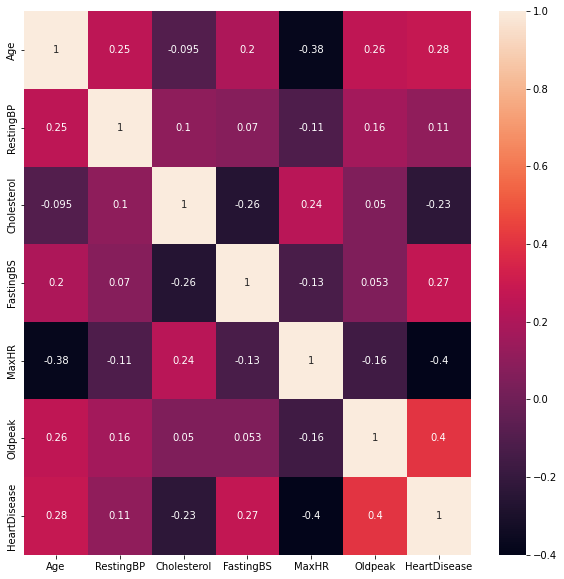

In [254]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(method ='pearson'),annot=True)

In [255]:
df_numeric=df[numeric]

In [256]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    '''
    Take the inputs as dataframe and calculate the VIF.
    Returns Data frame with VIF value and respective column name.
    
        Parameters:
                X(Data Frame):Pandas Data Farame
        
        Returns:
                vif(Data Frame): Data frame with VIF value and respective column name.
    '''
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif.sort_values(by='VIF'))

In [257]:
calc_vif(df_numeric[df_numeric.columns[:-1]])

,variables,VIF
3,FastingBS,1.450001
2,Cholesterol,4.944262
4,MaxHR,19.098605
0,Age,28.227758
1,RestingBP,41.908436


In [258]:
def check_muticolinearity(dataframe,threshold = 0.9):
    
    '''
    Take the inputs as dataframe and threshold of correlation.
    Print the number of column and respective column names to be droped.
    
        Parameters:
                dataframe(Data Frame):Pandas Data Farame
        
        Returns:
                Print the number of column and respective column names to be droped.
    
    '''
    corr_matrix =dataframe.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    if len(to_drop)>1:
        print(f'There are {len(to_drop)} columns to remove. And they are {to_drop}')
    else:
         print(f'There are {len(to_drop)} columns to remove.')  

In [259]:
check_muticolinearity(df_numeric[df_numeric.columns[:-1]])

There are 0 columns to remove.


## EDA

In [260]:
df_raw['HeartDisease']=df_raw['HeartDisease'].map({0:'No', 1:'Yes'})

In [261]:
numeric_new=[]
for label,content in df_raw.items():
    if pd.api.types.is_numeric_dtype(content):
        numeric_new.append(label)
numeric_new

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [262]:
numericdf=df_raw[numeric_new]

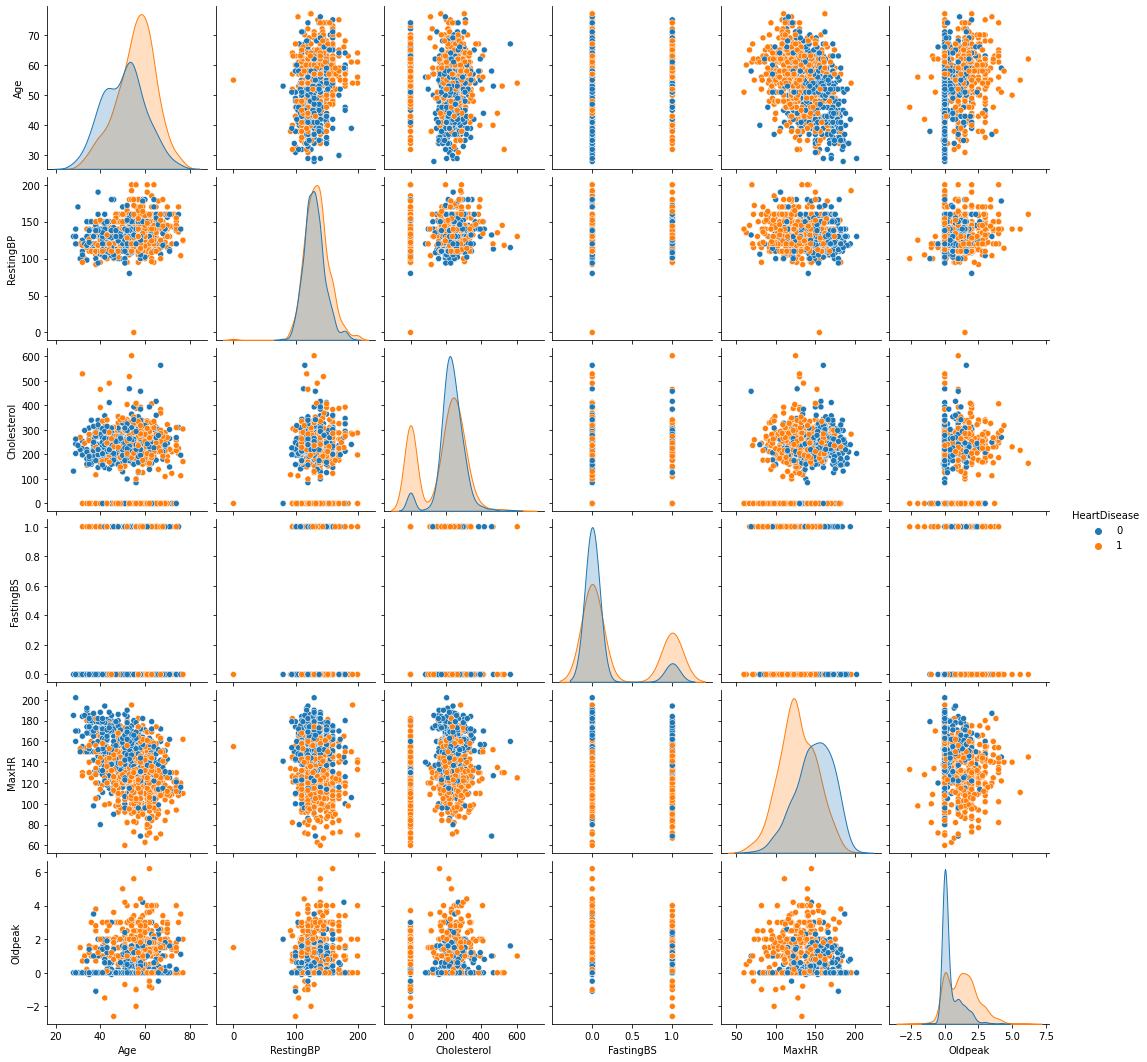

In [263]:
sns.pairplot(df,hue='HeartDisease')

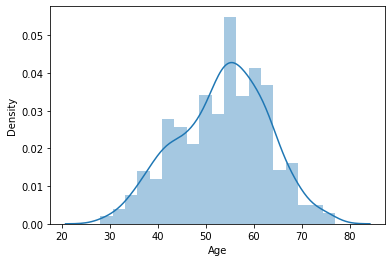

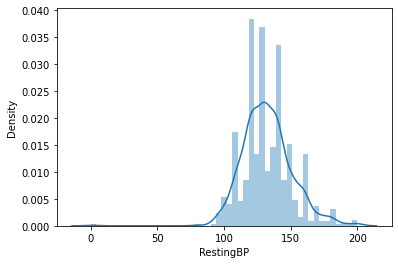

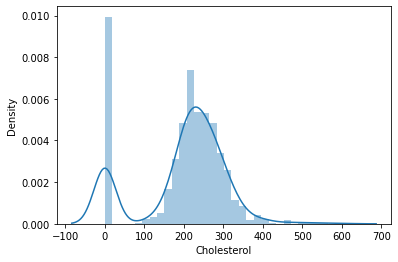

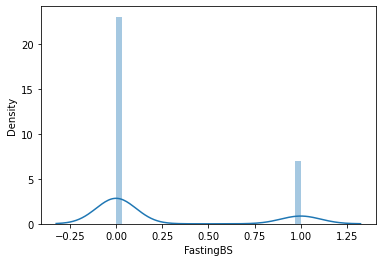

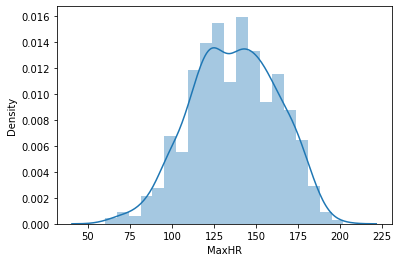

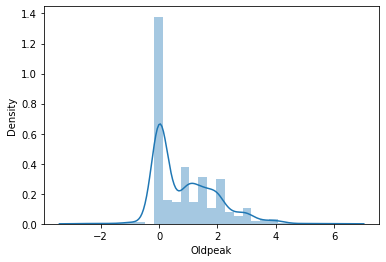

In [264]:
for i in numericdf.columns:
    sns.distplot(numericdf[i])
    plt.show()

In [265]:
not_numeric_new=[]
for label,content in df_raw.items():
    if not pd.api.types.is_numeric_dtype(content):
        not_numeric_new.append(label)
not_numeric_new

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'HeartDisease']

In [266]:
nonnumericdf=df_raw[not_numeric_new]

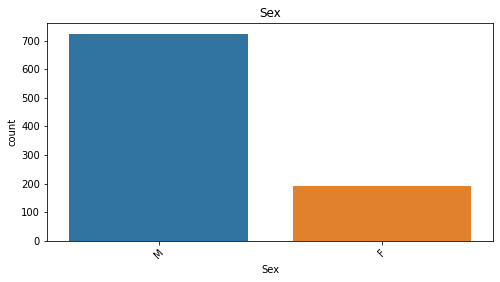

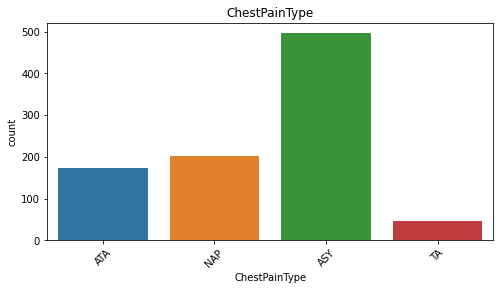

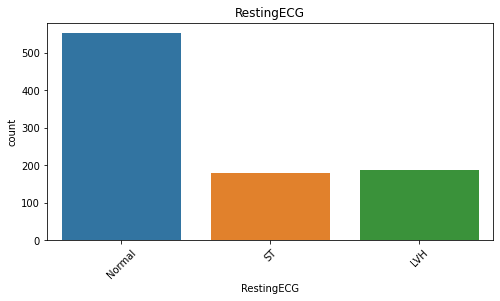

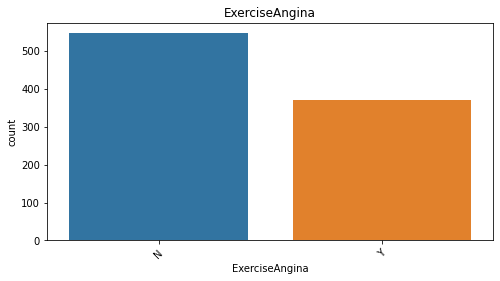

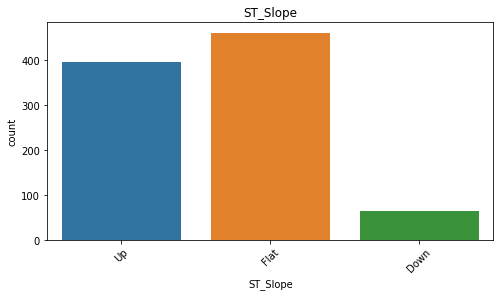

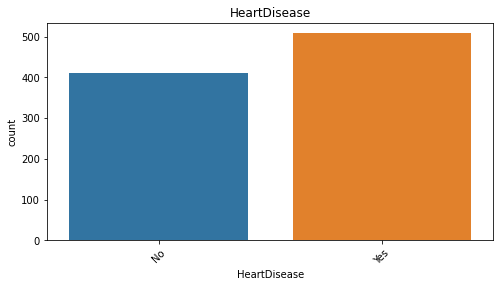

In [267]:
for col in not_numeric_new:
    plt.figure(figsize=(8,4))
    sns.countplot(x=nonnumericdf[col], data=nonnumericdf)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

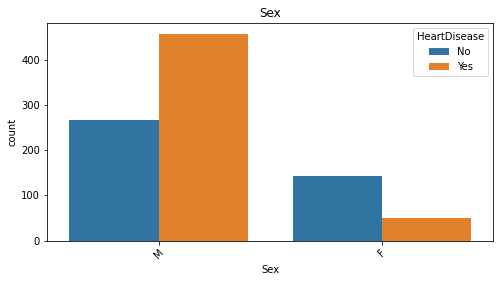

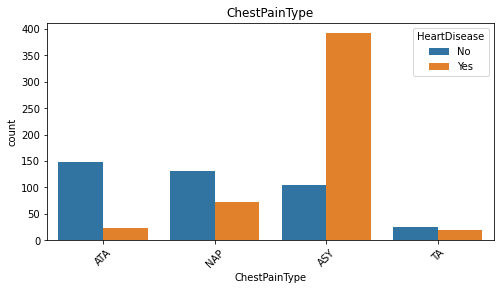

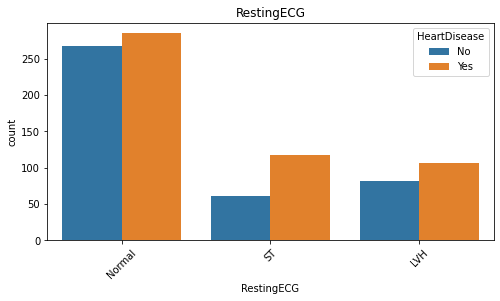

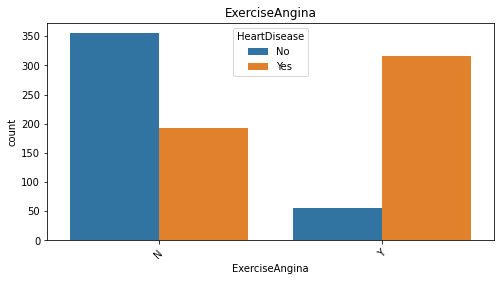

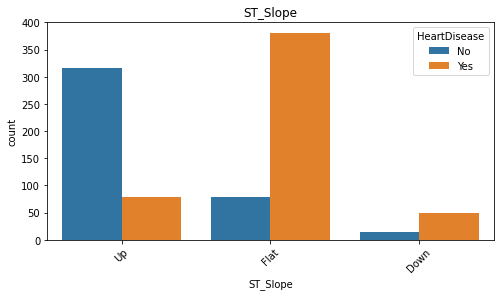

In [268]:
for col in not_numeric_new[:-1]:
    plt.figure(figsize=(8,4))
    sns.countplot(x=nonnumericdf[col], data=nonnumericdf,hue='HeartDisease')
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

In [269]:
from scipy import stats

In [270]:
def probaplot(col):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    stats.probplot(df[col],dist='norm',plot=plt)
    
    plt.subplot(1,2,2)
    sns.boxplot(df[col],color='red')
    
    plt.show()

Prob Plot of Age


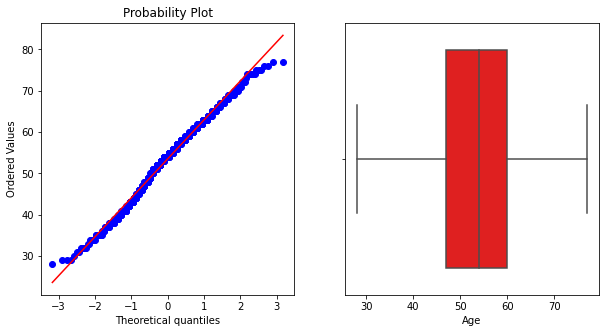

____________________________________________________________________________________________________ 

Prob Plot of RestingBP


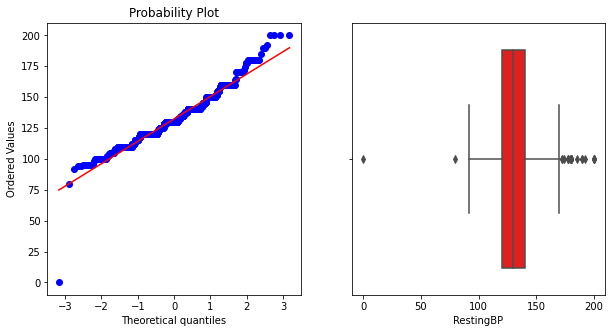

____________________________________________________________________________________________________ 

Prob Plot of Cholesterol


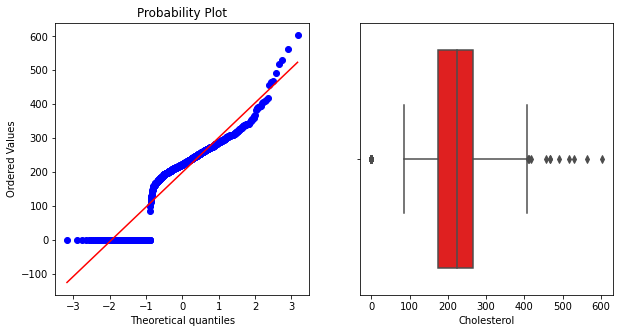

____________________________________________________________________________________________________ 

Prob Plot of FastingBS


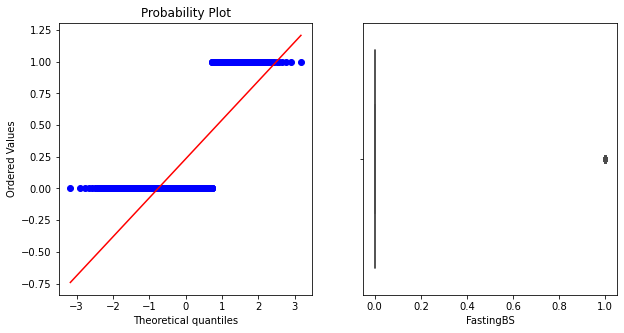

____________________________________________________________________________________________________ 

Prob Plot of MaxHR


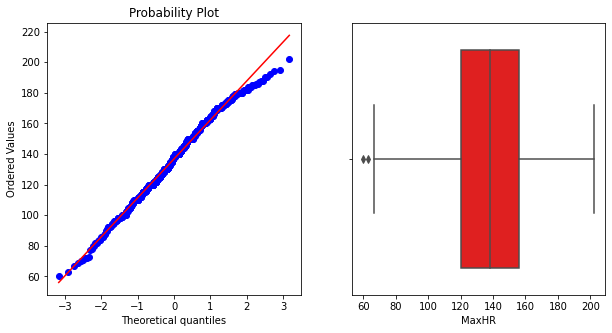

____________________________________________________________________________________________________ 

Prob Plot of Oldpeak


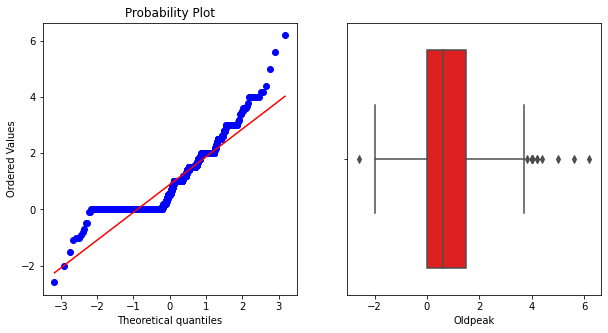

____________________________________________________________________________________________________ 



In [271]:
for i in numericdf.columns:
    print(f'Prob Plot of {i}')
    probaplot(i)
    print('_'*100,'\n')
    plt.show()

## Encoding

In [272]:
not_numeric=[]
for label,content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        not_numeric.append(label)
not_numeric

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [273]:
for col in not_numeric:
    print(f"\033[1m{col} \n{20 * '-'}\033[0m")
    print(f"\033[1m Unique :{df[col].nunique()}\n{20 * '-'}\033[0m")
    print(f"{20 * '-'}")
    print(df[col].value_counts(), '\n')

Sex 
--------------------
 Unique :2
--------------------
--------------------
M    725
F    193
Name: Sex, dtype: int64 

ChestPainType 
--------------------
 Unique :4
--------------------
--------------------
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64 

RestingECG 
--------------------
 Unique :3
--------------------
--------------------
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64 

ExerciseAngina 
--------------------
 Unique :2
--------------------
--------------------
N    547
Y    371
Name: ExerciseAngina, dtype: int64 

ST_Slope 
--------------------
 Unique :3
--------------------
--------------------
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64 



### One Hot Encoding

In [274]:
df=pd.get_dummies(df,columns=['ST_Slope','RestingECG','ChestPainType'])

### Label Encoding

In [275]:
def labelEncoding(col,encoder):
    df[col]=encoder.fit_transform(df[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

In [276]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

In [277]:
list_label=['Sex','ExerciseAngina']
for col in list_label:
    labelEncoding(col,le)

{'F': 0, 'M': 1}
{'N': 0, 'Y': 1}


In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   Sex                918 non-null    int32  
 2   RestingBP          918 non-null    int64  
 3   Cholesterol        918 non-null    int64  
 4   FastingBS          918 non-null    int64  
 5   MaxHR              918 non-null    int64  
 6   ExerciseAngina     918 non-null    int32  
 7   Oldpeak            918 non-null    float64
 8   HeartDisease       918 non-null    int64  
 9   ST_Slope_Down      918 non-null    uint8  
 10  ST_Slope_Flat      918 non-null    uint8  
 11  ST_Slope_Up        918 non-null    uint8  
 12  RestingECG_LVH     918 non-null    uint8  
 13  RestingECG_Normal  918 non-null    uint8  
 14  RestingECG_ST      918 non-null    uint8  
 15  ChestPainType_ASY  918 non-null    uint8  
 16  ChestPainType_ATA  918 non

## Imputation

### Zero value of cholesterol are filled usnig KNNImputer

In [279]:
df['Cholesterol'].describe()

count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [280]:
#Zero value of cholesterol are filled usnig KNNImputer
from sklearn.impute import KNNImputer
df['Cholesterol'].replace(to_replace = 0, value =np.nan, inplace=True)
KNN_imputed = KNNImputer(n_neighbors=5)
I=KNN_imputed.fit_transform(df)

In [281]:
print(df.describe().columns)
len(df.describe().columns)

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up', 'RestingECG_LVH', 'RestingECG_Normal',
       'RestingECG_ST', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA'],
      dtype='object')


19

In [282]:
print(I[0])
print(len(I[0]))

[ 40.   1. 140. 289.   0. 172.   0.   0.   0.   0.   0.   1.   0.   1.
   0.   0.   1.   0.   0.]
19


#### 'Cholesterol' is forth that is I[0][3]

In [283]:
Cholesterol=[]
for i in range(0,len(df)):
  Cholesterol.append(I[i][3])
df['Cholesterol']=Cholesterol

In [284]:
df['Cholesterol'].describe()

count    918.000000
mean     244.918083
std       54.665704
min       85.000000
25%      212.000000
50%      239.100000
75%      272.850000
max      603.000000
Name: Cholesterol, dtype: float64

## Outlier

In [286]:
from scipy import stats

In [288]:
df.shape

(918, 19)

In [289]:
df_new=df[(np.abs(stats.zscore(df))<3).all(axis=1)]

In [290]:
df_new.shape

(793, 19)

<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

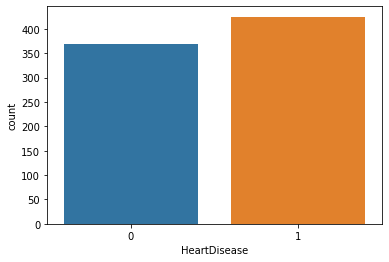

In [291]:
sns.countplot(df_new['HeartDisease'])

In [292]:
X=df.drop('HeartDisease',axis=1)
y=df['HeartDisease']

## Splitting of DATA

In [293]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Scalling

In [294]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

In [295]:
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

# Model

In [297]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score,balanced_accuracy_score,f1_score

In [298]:
M1=LogisticRegression()
M1.fit(X_train,y_train)
P1=M1.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P1))
print('\n')
print('classification_report')
print(classification_report(y_test,P1))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P1))
print('\n')
print('Roc Value:',roc_auc_score(y_test,M1.predict(X_test)))

confusion_matrix
[[111  12]
 [ 32 148]]


classification_report
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       123
           1       0.93      0.82      0.87       180

    accuracy                           0.85       303
   macro avg       0.85      0.86      0.85       303
weighted avg       0.86      0.85      0.86       303



Accuracy: 85.47854785478548


Roc Value: 0.862330623306233


## Decision Tree

In [300]:
from sklearn.tree import DecisionTreeClassifier

In [301]:
M2=DecisionTreeClassifier()
M2.fit(X_train,y_train)
P2=M2.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P2))
print('\n')
print('classification_report')
print(classification_report(y_test,P2))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P2))
print('\n')
print('Roc Value:',roc_auc_score(y_test,M2.predict(X_test)))

confusion_matrix
[[100  23]
 [ 58 122]]


classification_report
              precision    recall  f1-score   support

           0       0.63      0.81      0.71       123
           1       0.84      0.68      0.75       180

    accuracy                           0.73       303
   macro avg       0.74      0.75      0.73       303
weighted avg       0.76      0.73      0.73       303



Accuracy: 73.26732673267327


Roc Value: 0.7453929539295393


## RandomForest

In [302]:
from sklearn.ensemble import RandomForestClassifier

In [303]:
M3=RandomForestClassifier()
M3.fit(X_train,y_train)
P3=M3.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P3))
print('\n')
print('classification_report')
print(classification_report(y_test,P3))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P3))
print('\n')
print('Roc Value:',roc_auc_score(y_test,M3.predict(X_test)))

confusion_matrix
[[112  11]
 [ 32 148]]


classification_report
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       123
           1       0.93      0.82      0.87       180

    accuracy                           0.86       303
   macro avg       0.85      0.87      0.86       303
weighted avg       0.87      0.86      0.86       303



Accuracy: 85.8085808580858


Roc Value: 0.8663956639566396


## SVM

In [304]:
from sklearn.svm import SVC

In [305]:
M4=SVC()
M4.fit(X_train,y_train)
P4=M4.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P4))
print('\n')
print('classification_report')
print(classification_report(y_test,P4))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P4))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P4))

confusion_matrix
[[107  16]
 [ 28 152]]


classification_report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       123
           1       0.90      0.84      0.87       180

    accuracy                           0.85       303
   macro avg       0.85      0.86      0.85       303
weighted avg       0.86      0.85      0.86       303



Accuracy: 85.47854785478548


ROC Value: 0.8571815718157182


## KNN

In [306]:
from sklearn.neighbors import KNeighborsClassifier

Text(0, 0.5, 'Error Rate')

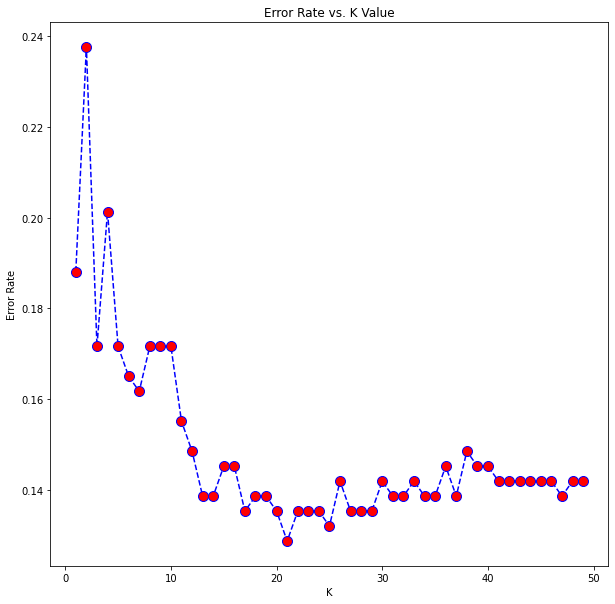

In [307]:
error_Mat=[]
for i in range (1,50):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    predict_i=knn.predict(X_test)
    error_Mat.append(np.mean(predict_i != y_test))
plt.figure(figsize=(10,10))
plt.plot(range(1,50),error_Mat,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [308]:
M5=KNeighborsClassifier(n_neighbors=7)
M5.fit(X_train,y_train)
P5=M5.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P5))
print('\n')
print('classification_report')
print(classification_report(y_test,P5))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P5))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P5))

confusion_matrix
[[110  13]
 [ 36 144]]


classification_report
              precision    recall  f1-score   support

           0       0.75      0.89      0.82       123
           1       0.92      0.80      0.85       180

    accuracy                           0.84       303
   macro avg       0.84      0.85      0.84       303
weighted avg       0.85      0.84      0.84       303



Accuracy: 83.82838283828383


ROC Value: 0.8471544715447155


## Naive_bayes

In [309]:
from sklearn.naive_bayes import GaussianNB

In [310]:
M6=GaussianNB()
M6.fit(X_train,y_train)
P6=M6.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P6))
print('\n')
print('classification_report')
print(classification_report(y_test,P6))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P6))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P6))

confusion_matrix
[[110  13]
 [ 34 146]]


classification_report
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       123
           1       0.92      0.81      0.86       180

    accuracy                           0.84       303
   macro avg       0.84      0.85      0.84       303
weighted avg       0.86      0.84      0.85       303



Accuracy: 84.48844884488449


ROC Value: 0.852710027100271


## GradientBoostingClassifier

In [311]:
from sklearn.ensemble import GradientBoostingClassifier

In [312]:
M7=GradientBoostingClassifier()
M7.fit(X_train,y_train)
P7=M7.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P7))
print('\n')
print('classification_report')
print(classification_report(y_test,P7))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P7))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P7))

confusion_matrix
[[110  13]
 [ 33 147]]


classification_report
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       123
           1       0.92      0.82      0.86       180

    accuracy                           0.85       303
   macro avg       0.84      0.86      0.85       303
weighted avg       0.86      0.85      0.85       303



Accuracy: 84.81848184818482


ROC Value: 0.8554878048780488


## HistGradientBoostingClassifier

In [313]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [314]:
M8=HistGradientBoostingClassifier()
M8.fit(X_train,y_train)
P8=M8.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P8))
print('\n')
print('classification_report')
print(classification_report(y_test,P8))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P8))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P8))

confusion_matrix
[[109  14]
 [ 40 140]]


classification_report
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       123
           1       0.91      0.78      0.84       180

    accuracy                           0.82       303
   macro avg       0.82      0.83      0.82       303
weighted avg       0.84      0.82      0.82       303



Accuracy: 82.17821782178217


ROC Value: 0.8319783197831978


## CatBoostClassifier

In [315]:
from catboost import CatBoostClassifier

In [316]:
M9=CatBoostClassifier(verbose=0)
M9.fit(X_train,y_train)
P9=M9.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P9))
print('\n')
print('classification_report')
print(classification_report(y_test,P9))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P9))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P9))

confusion_matrix
[[110  13]
 [ 28 152]]


classification_report
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       123
           1       0.92      0.84      0.88       180

    accuracy                           0.86       303
   macro avg       0.86      0.87      0.86       303
weighted avg       0.87      0.86      0.87       303



Accuracy: 86.46864686468648


ROC Value: 0.8693766937669377


## XGBClassifier

In [317]:
from xgboost import XGBClassifier

In [318]:
M10=XGBClassifier()
M10.fit(X_train,y_train)
P10=M10.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P10))
print('\n')
print('classification_report')
print(classification_report(y_test,P10))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P10))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P10))

confusion_matrix
[[107  16]
 [ 33 147]]


classification_report
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       123
           1       0.90      0.82      0.86       180

    accuracy                           0.84       303
   macro avg       0.83      0.84      0.84       303
weighted avg       0.85      0.84      0.84       303



Accuracy: 83.82838283828383


ROC Value: 0.8432926829268292


## LGBMClassifier

In [319]:
from lightgbm import LGBMClassifier

In [321]:
M11=LGBMClassifier()
M11.fit(X_train,y_train)
P11=M11.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P11))
print('\n')
print('classification_report')
print(classification_report(y_test,P11))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P11))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P11))

confusion_matrix
[[108  15]
 [ 35 145]]


classification_report
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       123
           1       0.91      0.81      0.85       180

    accuracy                           0.83       303
   macro avg       0.83      0.84      0.83       303
weighted avg       0.84      0.83      0.84       303



Accuracy: 83.4983498349835


ROC Value: 0.8418021680216803


## Neural_network

In [322]:
from sklearn.neural_network import MLPClassifier

In [325]:
M12=MLPClassifier(hidden_layer_sizes=(50,))
M12.fit(X_train,y_train)
P12=M12.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P12))
print('\n')
print('classification_report')
print(classification_report(y_test,P12))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P12))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P12))

confusion_matrix
[[112  11]
 [ 28 152]]


classification_report
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       123
           1       0.93      0.84      0.89       180

    accuracy                           0.87       303
   macro avg       0.87      0.88      0.87       303
weighted avg       0.88      0.87      0.87       303



Accuracy: 87.12871287128714


ROC Value: 0.8775067750677507


## BaggingClassifier

In [326]:
from sklearn.ensemble import BaggingClassifier

In [349]:
M13=BaggingClassifier(base_estimator=CatBoostClassifier(verbose=0))
M13.fit(X_train,y_train)
P13=M13.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P13))
print('\n')
print('classification_report')
print(classification_report(y_test,P13))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P13))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P13))

confusion_matrix
[[112  11]
 [ 28 152]]


classification_report
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       123
           1       0.93      0.84      0.89       180

    accuracy                           0.87       303
   macro avg       0.87      0.88      0.87       303
weighted avg       0.88      0.87      0.87       303



Accuracy: 87.12871287128714


ROC Value: 0.8775067750677507


## LinearSVC

In [329]:
from sklearn.svm import LinearSVC

In [331]:
M14=LinearSVC()
M14.fit(X_train,y_train)
P14=M14.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P14))
print('\n')
print('classification_report')
print(classification_report(y_test,P14))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P14))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P14))

confusion_matrix
[[111  12]
 [ 28 152]]


classification_report
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       123
           1       0.93      0.84      0.88       180

    accuracy                           0.87       303
   macro avg       0.86      0.87      0.87       303
weighted avg       0.87      0.87      0.87       303



Accuracy: 86.79867986798679


ROC Value: 0.8734417344173443


## SGD Classifier

In [332]:
from sklearn.linear_model import SGDClassifier

In [334]:
M15=SGDClassifier()
M15.fit(X_train,y_train)
P15=M15.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P15))
print('\n')
print('classification_report')
print(classification_report(y_test,P15))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P15))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P15))

confusion_matrix
[[101  22]
 [ 36 144]]


classification_report
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       123
           1       0.87      0.80      0.83       180

    accuracy                           0.81       303
   macro avg       0.80      0.81      0.80       303
weighted avg       0.81      0.81      0.81       303



Accuracy: 80.85808580858085


ROC Value: 0.8105691056910569


## Perceptron

In [336]:
from sklearn.linear_model import Perceptron

In [338]:
M16=Perceptron()
M16.fit(X_train,y_train)
P16=M16.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P16))
print('\n')
print('classification_report')
print(classification_report(y_test,P16))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P16))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P16))

confusion_matrix
[[ 98  25]
 [ 51 129]]


classification_report
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       123
           1       0.84      0.72      0.77       180

    accuracy                           0.75       303
   macro avg       0.75      0.76      0.75       303
weighted avg       0.76      0.75      0.75       303



Accuracy: 74.91749174917491


ROC Value: 0.7567073170731707


## LogisticRegressionCV

In [339]:
from sklearn.linear_model import LogisticRegressionCV

In [341]:
M17=LogisticRegressionCV()
M17.fit(X_train,y_train)
P17=M17.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P17))
print('\n')
print('classification_report')
print(classification_report(y_test,P17))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P17))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P17))

confusion_matrix
[[109  14]
 [ 24 156]]


classification_report
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       123
           1       0.92      0.87      0.89       180

    accuracy                           0.87       303
   macro avg       0.87      0.88      0.87       303
weighted avg       0.88      0.87      0.88       303



Accuracy: 87.45874587458746


ROC Value: 0.8764227642276423


## CalibratedClassifierCV

In [343]:
from sklearn.calibration import CalibratedClassifierCV

In [344]:
M18=CalibratedClassifierCV(M6, cv=2)
M18.fit(X_train,y_train)
P18=M18.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P18))
print('\n')
print('classification_report')
print(classification_report(y_test,P18))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P18))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P18))

confusion_matrix
[[110  13]
 [ 34 146]]


classification_report
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       123
           1       0.92      0.81      0.86       180

    accuracy                           0.84       303
   macro avg       0.84      0.85      0.84       303
weighted avg       0.86      0.84      0.85       303



Accuracy: 84.48844884488449


ROC Value: 0.852710027100271


## PassiveAggressiveClassifier

In [345]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [346]:
M19=PassiveAggressiveClassifier(max_iter=5000, random_state=0,tol=1e-3)
M19.fit(X_train,y_train)
P19=M19.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P19))
print('\n')
print('classification_report')
print(classification_report(y_test,P19))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P19))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P19))

confusion_matrix
[[110  13]
 [ 43 137]]


classification_report
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       123
           1       0.91      0.76      0.83       180

    accuracy                           0.82       303
   macro avg       0.82      0.83      0.81       303
weighted avg       0.83      0.82      0.82       303



Accuracy: 81.51815181518151


ROC Value: 0.827710027100271


## QuadraticDiscriminantAnalysis

In [347]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [348]:
M20=QuadraticDiscriminantAnalysis()
M20.fit(X_train,y_train)
P20=M20.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P20))
print('\n')
print('classification_report')
print(classification_report(y_test,P20))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P20))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P20))

confusion_matrix
[[102  21]
 [ 26 154]]


classification_report
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       123
           1       0.88      0.86      0.87       180

    accuracy                           0.84       303
   macro avg       0.84      0.84      0.84       303
weighted avg       0.85      0.84      0.85       303



Accuracy: 84.48844884488449


ROC Value: 0.8424119241192412


## RidgeClassifierCV

In [350]:
from sklearn.linear_model import RidgeClassifierCV

In [351]:
M21=RidgeClassifierCV()
M21.fit(X_train,y_train)
P21=M21.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P21))
print('\n')
print('classification_report')
print(classification_report(y_test,P21))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P21))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P21))

confusion_matrix
[[111  12]
 [ 29 151]]


classification_report
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       123
           1       0.93      0.84      0.88       180

    accuracy                           0.86       303
   macro avg       0.86      0.87      0.86       303
weighted avg       0.87      0.86      0.87       303



Accuracy: 86.46864686468648


ROC Value: 0.8706639566395665


## RidgeClassifier

In [352]:
from sklearn.linear_model import RidgeClassifier

In [353]:
M22=RidgeClassifier()
M22.fit(X_train,y_train)
P22=M22.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P22))
print('\n')
print('classification_report')
print(classification_report(y_test,P22))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P22))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P22))

confusion_matrix
[[111  12]
 [ 29 151]]


classification_report
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       123
           1       0.93      0.84      0.88       180

    accuracy                           0.86       303
   macro avg       0.86      0.87      0.86       303
weighted avg       0.87      0.86      0.87       303



Accuracy: 86.46864686468648


ROC Value: 0.8706639566395665


## ExtraTreesClassifier

In [355]:
from sklearn.ensemble import ExtraTreesClassifier

In [356]:
M23=ExtraTreesClassifier()
M23.fit(X_train,y_train)
P23=M23.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P23))
print('\n')
print('classification_report')
print(classification_report(y_test,P23))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P23))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P23))

confusion_matrix
[[111  12]
 [ 40 140]]


classification_report
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       123
           1       0.92      0.78      0.84       180

    accuracy                           0.83       303
   macro avg       0.83      0.84      0.83       303
weighted avg       0.85      0.83      0.83       303



Accuracy: 82.83828382838284


ROC Value: 0.8401084010840107


## BernoulliNB

In [358]:
from sklearn.naive_bayes import BernoulliNB

In [360]:
M24=BernoulliNB()
M24.fit(X_train,y_train)
P24=M24.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P24))
print('\n')
print('classification_report')
print(classification_report(y_test,P24))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P24))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P24))

confusion_matrix
[[110  13]
 [ 33 147]]


classification_report
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       123
           1       0.92      0.82      0.86       180

    accuracy                           0.85       303
   macro avg       0.84      0.86      0.85       303
weighted avg       0.86      0.85      0.85       303



Accuracy: 84.81848184818482


ROC Value: 0.8554878048780488


## LinearDiscriminantAnalysis

In [361]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [362]:
M25=LinearDiscriminantAnalysis()
M25.fit(X_train,y_train)
P25=M25.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P25))
print('\n')
print('classification_report')
print(classification_report(y_test,P25))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P25))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P25))

confusion_matrix
[[111  12]
 [ 29 151]]


classification_report
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       123
           1       0.93      0.84      0.88       180

    accuracy                           0.86       303
   macro avg       0.86      0.87      0.86       303
weighted avg       0.87      0.86      0.87       303



Accuracy: 86.46864686468648


ROC Value: 0.8706639566395665


## NuSVC

In [365]:
from sklearn.svm import NuSVC

In [366]:
M26=NuSVC()
M26.fit(X_train,y_train)
P26=M26.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P26))
print('\n')
print('classification_report')
print(classification_report(y_test,P26))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P26))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P26))

confusion_matrix
[[105  18]
 [ 29 151]]


classification_report
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       123
           1       0.89      0.84      0.87       180

    accuracy                           0.84       303
   macro avg       0.84      0.85      0.84       303
weighted avg       0.85      0.84      0.85       303



Accuracy: 84.48844884488449


ROC Value: 0.8462737127371275


## NearestCentroid

In [367]:
from sklearn.neighbors import NearestCentroid

In [368]:
M27=NearestCentroid()
M27.fit(X_train,y_train)
P27=M27.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P27))
print('\n')
print('classification_report')
print(classification_report(y_test,P27))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P27))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P27))

confusion_matrix
[[110  13]
 [ 31 149]]


classification_report
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       123
           1       0.92      0.83      0.87       180

    accuracy                           0.85       303
   macro avg       0.85      0.86      0.85       303
weighted avg       0.86      0.85      0.86       303



Accuracy: 85.47854785478548


ROC Value: 0.8610433604336042


## DummyClassifier

In [369]:
from sklearn.dummy import DummyClassifier

In [370]:
M28=DummyClassifier()
M28.fit(X_train,y_train)
P28=M28.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,P28))
print('\n')
print('classification_report')
print(classification_report(y_test,P28))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,P28))
print('\n')
print('ROC Value:',roc_auc_score(y_test,P28))

confusion_matrix
[[  0 123]
 [  0 180]]


classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       123
           1       0.59      1.00      0.75       180

    accuracy                           0.59       303
   macro avg       0.30      0.50      0.37       303
weighted avg       0.35      0.59      0.44       303



Accuracy: 59.4059405940594


ROC Value: 0.5


In [371]:
Name=['Logistic Regression','Random Forest Classifier','Decision Tree','Naive Bayes classifier', 'SVM','KNN', 
      'GBBoosting','Histogram Boosting Classifier','XGB Boosting','Light GBM',
      'CAT Boosting','Neural_Network','Bagging_classifier','LinearSVC','SGD Classifier','Perceptron','LogisticRegressionCV',
     'CalibratedClassifierCV','PassiveAggressiveClassifier','QuadraticDiscriminantAnalysis','RidgeClassifierCV',
     'RidgeClassifier','ExtraTreesClassifier','BernoulliNB','LinearDiscriminantAnalysis ','NuSVC','NearestCentroid',
      'DummyClassifier']
clfs= [LogisticRegression(),RandomForestClassifier(),DecisionTreeClassifier(),GaussianNB(),SVC(),KNeighborsClassifier(n_neighbors=2),
      GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1),
       HistGradientBoostingClassifier(),XGBClassifier(),LGBMClassifier(),MLPClassifier(),
       CatBoostClassifier(verbose=0),BaggingClassifier(base_estimator=GradientBoostingClassifier()),LinearSVC(),SGDClassifier(),
      Perceptron(),LogisticRegressionCV(),CalibratedClassifierCV(GaussianNB(), cv=2),
       PassiveAggressiveClassifier(max_iter=1000, random_state=0,tol=1e-3),QuadraticDiscriminantAnalysis(),
      RidgeClassifierCV(),RidgeClassifier(),ExtraTreesClassifier(),BernoulliNB(),LinearDiscriminantAnalysis(),NuSVC(),
       NearestCentroid(),DummyClassifier()]

In [372]:
Roc_score=[]
Accuracy_score=[]
Balenced_accuracy=[]
F1_score=[]
Confusion_metrix=[]
Classification_Report=[]

for i in clfs:
    i.fit(X_train,y_train)
    
    Roc_value=roc_auc_score(y_test,i.predict(X_test))
    acc_value=100*accuracy_score(y_test,i.predict(X_test))
    Bal_acc_value=balanced_accuracy_score(y_test,i.predict(X_test))
    F1_value=f1_score(y_test,i.predict(X_test))
    Confusion_metrix_value=confusion_matrix(y_test,i.predict(X_test))
    Classification_Report_value=classification_report(y_test,i.predict(X_test))
    
    Roc_score.append(Roc_value)
    Accuracy_score.append(acc_value)
    Balenced_accuracy.append(Bal_acc_value)
    F1_score.append(F1_value)
    Confusion_metrix.append(Confusion_metrix_value)
    Classification_Report.append(Classification_Report_value)

In [373]:
dict={'AROC':Roc_score ,'Accuracy':Accuracy_score,'Bal Accu':Balenced_accuracy,'F1 Score':F1_score}
score = pd.DataFrame(dict, index=Name)
score=score.sort_values(by='AROC',ascending=False)
print(score)

                                   AROC   Accuracy  Bal Accu  F1 Score
CAT Boosting                   0.884146  87.458746  0.884146  0.887574
Random Forest Classifier       0.878997  87.458746  0.878997  0.890173
LogisticRegressionCV           0.876423  87.458746  0.876423  0.891429
RidgeClassifierCV              0.870664  86.468647  0.870664  0.880466
RidgeClassifier                0.870664  86.468647  0.870664  0.880466
LinearSVC                      0.870664  86.468647  0.870664  0.880466
LinearDiscriminantAnalysis     0.870664  86.468647  0.870664  0.880466
Neural_Network                 0.869377  86.468647  0.869377  0.881159
Logistic Regression            0.862331  85.478548  0.862331  0.870588
NearestCentroid                0.861043  85.478548  0.861043  0.871345
SVM                            0.857182  85.478548  0.857182  0.873563
BernoulliNB                    0.855488  84.818482  0.855488  0.864706
Bagging_classifier             0.855285  84.488449  0.855285  0.859701
Naive 

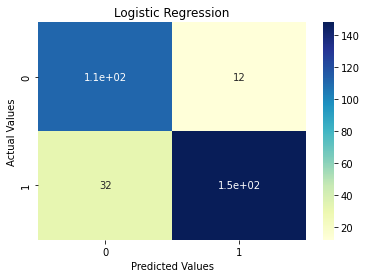

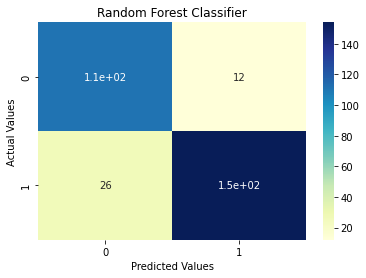

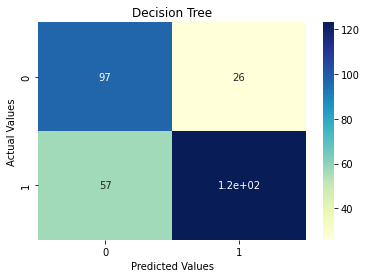

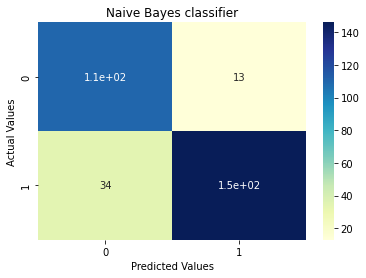

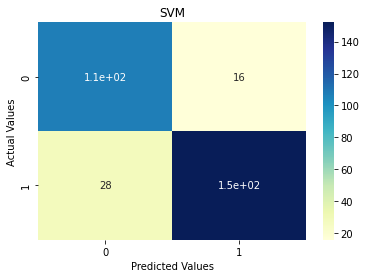

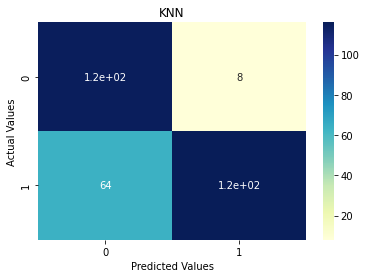

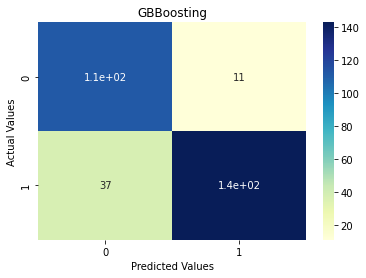

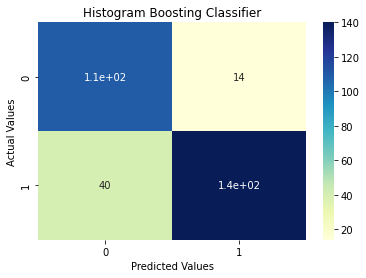

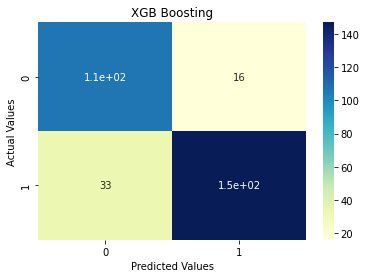

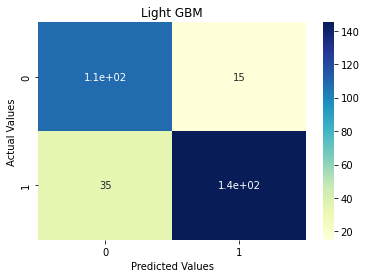

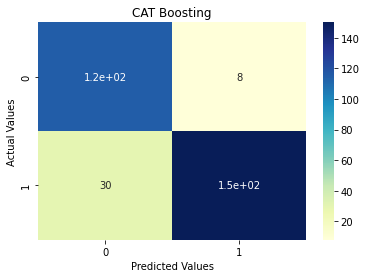

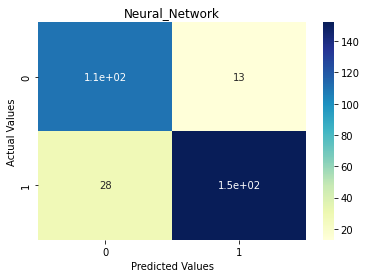

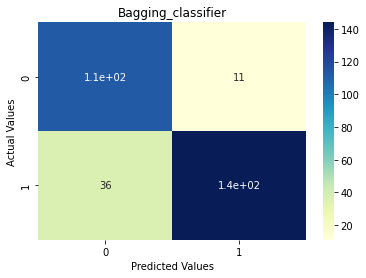

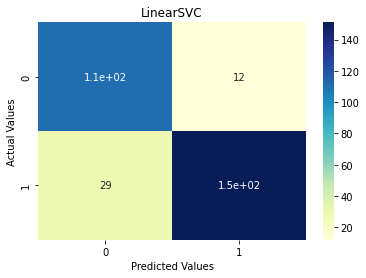

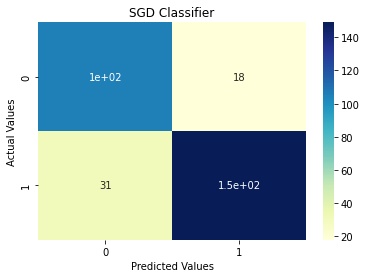

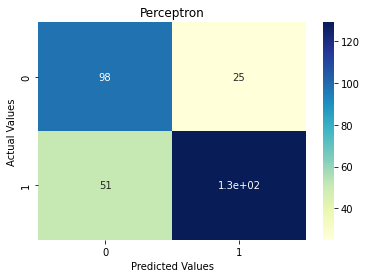

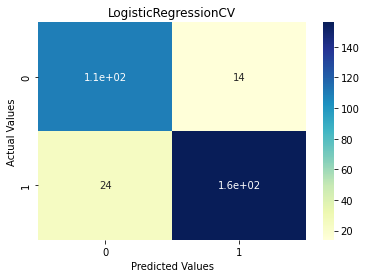

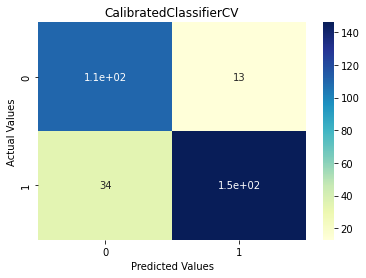

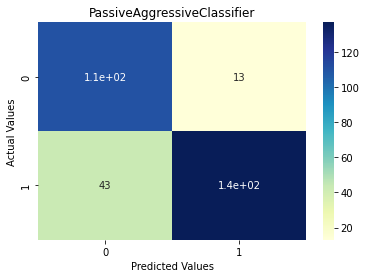

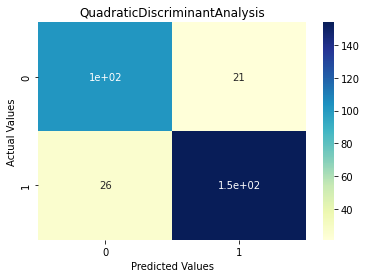

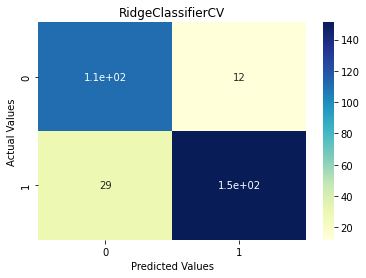

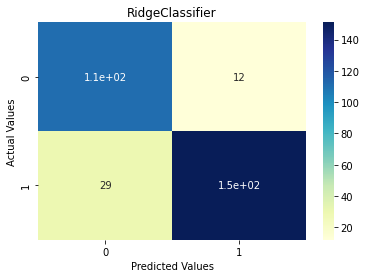

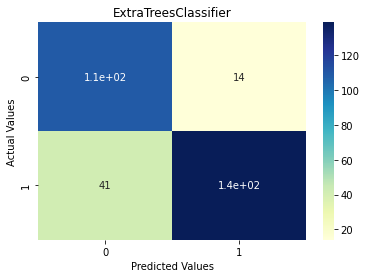

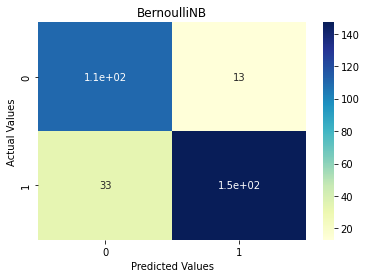

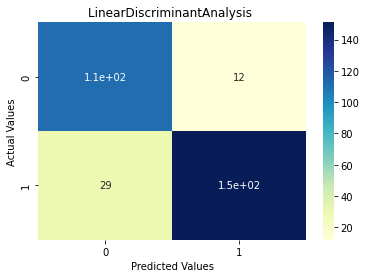

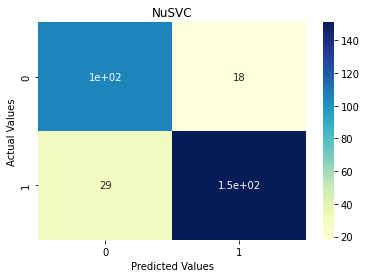

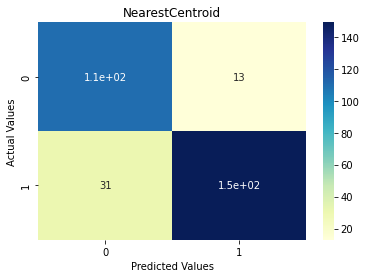

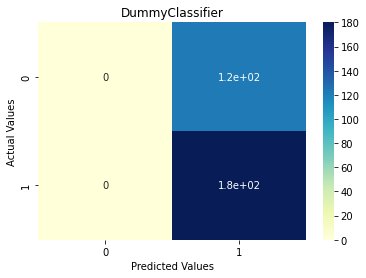

In [374]:
for i in range (len(Confusion_metrix)):
    ax = plt.axes()
    ax.set_title(Name[i])
    sns.heatmap(Confusion_metrix[i],annot=True,cmap="YlGnBu",ax=ax)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    plt.show()

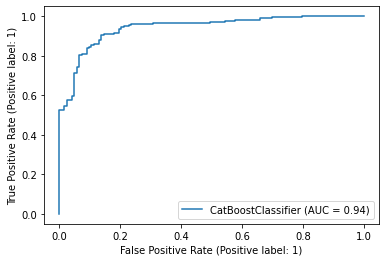

In [375]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
RocCurveDisplay.from_estimator(M9, X_test, y_test)

## Cross Validation

In [376]:
from sklearn.model_selection import KFold,cross_val_score

In [377]:
kfold=KFold(n_splits=5,shuffle=False, random_state=None)
kfold=KFold(n_splits=5,shuffle=False, random_state=None)
results_mean=[]

for i in clfs:
    csv=cross_val_score(i,X_train,y_train,cv=kfold)
    mean_score=csv.mean()
    results_mean.append(mean_score)

score= pd.DataFrame(results_mean,index=Name)
score.columns=['Accuracy']

In [378]:
score.sort_values(by='Accuracy',ascending=False)

,Accuracy
Neural_Network,0.855285
Bagging_classifier,0.853659
Random Forest Classifier,0.852033
SVM,0.852033
LinearDiscriminantAnalysis,0.850407
RidgeClassifier,0.850407
LogisticRegressionCV,0.848780
RidgeClassifierCV,0.848780
LinearSVC,0.847154
BernoulliNB,0.843902


In [398]:
score.sort_values(by='Accuracy',ascending=False)[:5]

,Accuracy
Neural_Network,0.855285
Bagging_classifier,0.853659
Random Forest Classifier,0.852033
SVM,0.852033
LinearDiscriminantAnalysis,0.850407


## Feature Selection

In [379]:
from sklearn.feature_selection import SelectFromModel, RFECV

In [380]:
model = RandomForestClassifier()

rfecv = RFECV(estimator=model, step=1, cv=kfold, scoring='accuracy', n_jobs=2)

rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 11


In [381]:
FSP1=rfecv.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test,FSP1))
print('\n')
print('classification_report')
print(classification_report(y_test,FSP1))
print('\n')
print('Accuracy:',100*accuracy_score(y_test,FSP1))
print('\n')
print('ROC Value:',roc_auc_score(y_test,FSP1))

confusion_matrix
[[110  13]
 [ 32 148]]


classification_report
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       123
           1       0.92      0.82      0.87       180

    accuracy                           0.85       303
   macro avg       0.85      0.86      0.85       303
weighted avg       0.86      0.85      0.85       303



Accuracy: 85.14851485148515


ROC Value: 0.8582655826558265


In [382]:
print('Best features :', X.columns[rfecv.support_])

Best features : Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'MaxHR', 'ExerciseAngina',
       'Oldpeak', 'ST_Slope_Flat', 'ST_Slope_Up', 'ChestPainType_ASY',
       'ChestPainType_ATA'],
      dtype='object')


In [388]:
df_1=df[['Age', 'Sex', 'RestingBP', 'Cholesterol', 'MaxHR', 'ExerciseAngina',
       'Oldpeak','HeartDisease']]

In [389]:
X_1=df_1.drop('HeartDisease',axis=1)
y_1=df_1['HeartDisease']

In [393]:
from sklearn.model_selection import train_test_split

In [394]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.33, random_state=42)

In [396]:
X_train_1=sc.fit_transform(X_train_1)
X_test_1=sc.transform(X_test_1)

In [397]:
M=RandomForestClassifier()
M.fit(X_train_1,y_train_1)
P=M.predict(X_test_1)
print('confusion_matrix')
print(confusion_matrix(y_test_1,P))
print('\n')
print('classification_report')
print(classification_report(y_test_1,P))
print('\n')
print('Accuracy:',100*accuracy_score(y_test_1,P))
print('\n')
print('ROC Value:',roc_auc_score(y_test_1,P))

confusion_matrix
[[101  22]
 [ 51 129]]


classification_report
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       123
           1       0.85      0.72      0.78       180

    accuracy                           0.76       303
   macro avg       0.76      0.77      0.76       303
weighted avg       0.78      0.76      0.76       303



Accuracy: 75.9075907590759


ROC Value: 0.7689024390243904


### Final Modals

In [399]:
import pickle
filename = 'Neural_network_model.pkl'
pickle.dump(M12, open(filename, 'wb'))

In [401]:
import pickle
filename = 'CatBoost_model.pkl'
pickle.dump(M19, open(filename, 'wb'))

In [402]:
import pickle
filename = 'Random_Forest_model.pkl'
pickle.dump(M3, open(filename, 'wb'))

In [403]:
import pickle
filename = 'SVM_model.pkl'
pickle.dump(M4, open(filename, 'wb'))

In [404]:
import pickle
filename = 'LDA_model.pkl'
pickle.dump(M25, open(filename, 'wb'))